In [1]:
from bs4 import BeautifulSoup
from shapely.geometry import Polygon

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Import and Parse XML

In [2]:
images = []
files = ['batch1.xml', 'batch2.xml', 'batch3.xml', 'batch4.xml']
for file in files:
    with open(file, 'r') as f:
        soup = BeautifulSoup(f.read(), "xml")
        for img in soup.find_all('image'):
            water_hyacinths = 0

            height = int(img.get('height'))
            width = int(img.get('width'))
            img_area = height * width 
            rivers = []
            water_hyacinths = []
            water_hyacinth_bounds = []
            garbage = []
            garbage_bounds = []
            boats = []
            others = []

            for polygon in img.find_all('polygon'):
                if(polygon.get('label') == 'river'):
                    coords = [p.split(',') for p in polygon.get('points').split(';')]
                    poly = Polygon(coords)
                    
                    rivers.append(poly.area)
                elif(polygon.get('label') == 'object'):
                    coords = [p.split(',') for p in polygon.get('points').split(';')]
                    poly = Polygon(coords)
                    
                    if(polygon.find('attribute').text == 'water hyacinth'):
                        water_hyacinths.append('%.2f' % poly.area)
                        water_hyacinth_bounds.append(','.join(['%.2f' % point for point in poly.bounds]))
                    elif(polygon.find('attribute').text == 'garbage'):
                        garbage.append('%.2f' % poly.area)
                        garbage_bounds.append(','.join(['%.2f' % point for point in poly.bounds]))
                    elif(polygon.find('attribute').text == 'boat'):
                        boats.append('%.2f' % poly.area)
                    elif(polygon.find('attribute').text == 'others'):
                        others.append('%.2f' % poly.area)
            
            if(len(rivers) > 1):
                print('%s has more than 1 river segment' % img.get('name'))
            river_area = sum(rivers)
            
            images.append({
                'name': img.get('name'),
                'height': height,
                'width': width,
                'area': img_area,
                'river_area': river_area,
                'river_relative_to_image': river_area / img_area if river_area else None,
                'water_hyacinths': ','.join(water_hyacinths),
                'water_hyacinth_bounds': '|'.join(water_hyacinth_bounds),
                'wh_count': len(water_hyacinths),
                'garbage': ','.join(garbage),
                'garbage_bounds': '|'.join(garbage_bounds),
                'g_count': len(garbage),
                'boats': ','.join(boats),
                'b_count': len(boats),
                'others': ','.join(others),
                'o_count': len(others),
            })

10b9ed1b6f7a1.jpg has more than 1 river segment
3c00c792e62bd.jpg has more than 1 river segment
621ede2509ce8.jpg has more than 1 river segment
654be90a139c2.jpg has more than 1 river segment
9af65325b6362.jpg has more than 1 river segment
fb92d0f220ba3.jpg has more than 1 river segment
82cf0240e3ba1.jpg has more than 1 river segment
73244ae953d8e.jpg has more than 1 river segment
cbb8872cf1cc8.jpg has more than 1 river segment
597efc9a76f19.jpg has more than 1 river segment
5ff75d6dba9b.jpg has more than 1 river segment
66fd99b75f6c7.jpg has more than 1 river segment


## Convert JSON to Pandas DataFrame

In [2]:
df = pd.DataFrame(images)

df.head()

NameError: name 'images' is not defined

In [3]:
df.to_json('annotation_statistics.json', orient='records')

NameError: name 'df' is not defined

In [2]:
df = pd.read_json('annotation_statistics.json')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     360 non-null    object 
 1   height                   360 non-null    int64  
 2   width                    360 non-null    int64  
 3   area                     360 non-null    int64  
 4   river_area               360 non-null    float64
 5   river_relative_to_image  360 non-null    float64
 6   water_hyacinths          360 non-null    object 
 7   water_hyacinth_bounds    360 non-null    object 
 8   wh_count                 360 non-null    int64  
 9   garbage                  360 non-null    object 
 10  garbage_bounds           360 non-null    object 
 11  g_count                  360 non-null    int64  
 12  boats                    360 non-null    object 
 13  b_count                  360 non-null    int64  
 14  others                   3

## Validation

### Check how images have missing rivers

In [7]:
df[df['river_area'] != df['river_area']]

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,garbage_bounds,g_count,boats,b_count,others,o_count


### Check how many rivers have less than 50% area of the image

In [8]:
df[df['river_relative_to_image'] < 0.5]

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,garbage_bounds,g_count,boats,b_count,others,o_count
19,3cee913a8e627.jpg,2250,4000,9000000,4.246180e+06,0.471798,"1759.92,1982.69,965.80,4480.71,14368.37,4176.6...","747.32,953.99,833.50,980.37|438.51,963.99,572....",7,,,0,,0,,0
55,a45229c7ea87c.jpg,2250,4000,9000000,4.175424e+06,0.463936,"897.59,3241.72,655.84,1157.77,35160.09","2226.23,1087.31,2282.72,1115.81|2261.35,991.63...",5,,,0,,0,,0
174,0809051412264.jpg,1440,2560,3686400,1.821153e+06,0.494019,"85.59,339.21,432.98","981.62,643.34,994.25,651.63|1103.95,630.52,115...",3,"40.93,803.85","47.40,701.75,58.52,706.26|1846.69,1245.56,1912...",2,,0,,0
219,c9f4e5978eeab.jpg,1440,2560,3686400,1.746068e+06,0.473651,"163.34,284.85,82.32,264.64,704.98","1171.05,938.64,1199.73,950.03|1329.00,750.00,1...",5,"146.37,414.50,1319.93,118.88","625.34,894.92,654.94,903.40|292.59,958.60,330....",4,,0,,0
239,e3bf24cb929d4.jpg,1440,2560,3686400,1.705196e+06,0.462564,"3340.90,308.75,137.01,319.09,124.73,986.46,929...","2288.91,1194.63,2397.26,1253.26|631.40,832.92,...",16,"661.64,286.17,49.79,119.83,148.03,1587.96","1443.93,1228.12,1494.58,1249.70|272.62,1215.60...",6,,0,,0
356,9bbf5b63e91e4.jpg,1440,2560,3686400,1.617173e+06,0.438686,"501.39,199.73,40.75,1058.42,530.19,55.93,684.8...","1380.24,838.03,1435.69,859.08|966.33,847.56,98...",18,"326.76,112.01,298.95,291.15","1654.26,1315.14,1695.31,1334.30|316.60,756.02,...",4,38925.27,1,,0


## Analysis and Visualization

### Visualize the number of images per image resolution

In [9]:
df['resolution'] = df.apply(lambda x: '%dx%d' % (x['height'], x['width']), axis=1)

Text(0.5, 1.0, 'Number of Images per Resolution')

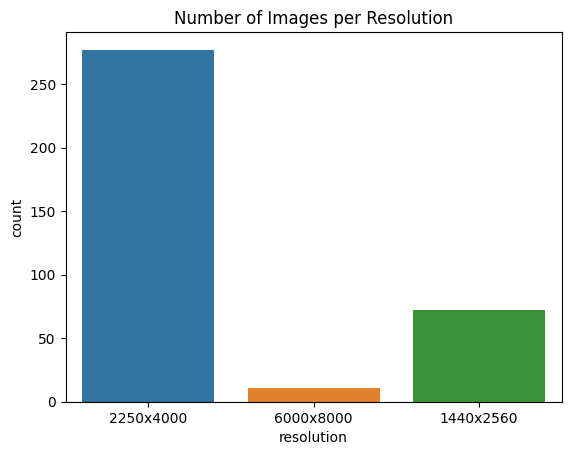

In [10]:
sns.countplot(df, x='resolution')

plt.title('Number of Images per Resolution')

### Amount of Objects per Image

In [3]:
df['n_objects'] = df.apply(lambda x: x['wh_count'] + x['g_count'] + x['b_count'] + x['o_count'], axis=1)

Text(0.5, 1.0, 'Distribution of Objects found per Image')

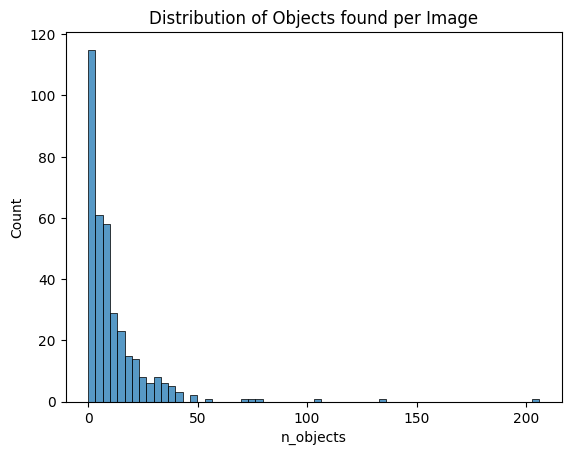

In [4]:
sns.histplot(df, x='n_objects')

plt.title('Distribution of Objects found per Image')

###  Objects Found

In [5]:
def check_objects_found(row):
    found = []
    if(row['wh_count'] > 0):
        found.append('wh')
    if(row['g_count'] > 0):
        found.append('g')
    if(row['b_count'] > 0):
        found.append('b')
    if(row['o_count'] > 0):
        found.append('o')
    return ','.join(found) if (len(found) > 0) else "none"

df['objects_found'] = df.apply(lambda x: check_objects_found(x), axis=1)

Text(0.5, 1.0, 'Number of Images with atleast 1 of the Corresponding Objects')

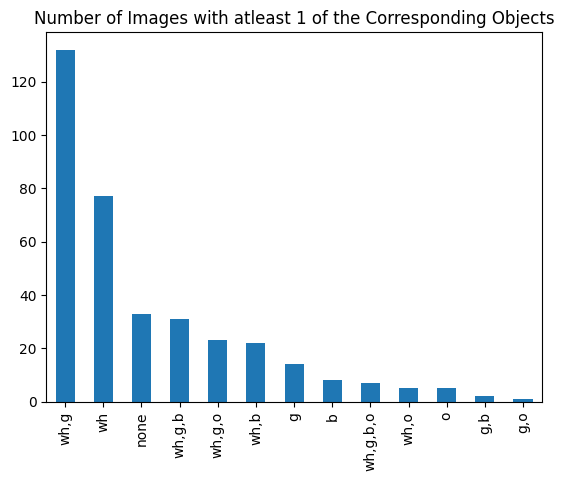

In [6]:
df['objects_found'].value_counts().plot(kind='bar')

plt.title("Number of Images with atleast 1 of the Corresponding Objects")

### River Coverage

Text(0.5, 1.0, 'Distribution of River Coverage')

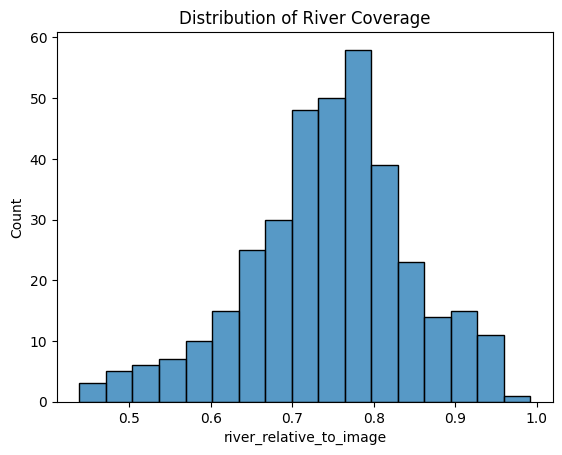

In [7]:
sns.histplot(df, x='river_relative_to_image')

plt.title("Distribution of River Coverage")

In [8]:
df['total_wh'] = df['water_hyacinths'].apply(lambda x: sum([float(val) for val in x.split(',') if val != '']))
df['total_g'] = df['garbage'].apply(lambda x: sum([float(val) for val in x.split(',') if val != '']))
df['total_b'] = df['boats'].apply(lambda x: sum([float(val) for val in x.split(',') if val != '']))
df['total_o'] = df['others'].apply(lambda x: sum([float(val) for val in x.split(',') if val != '']))

In [9]:
df['wh_relative_to_river'] = df['total_wh'] / df['river_area']
df['g_relative_to_river'] = df['total_g'] / df['river_area']
df['b_relative_to_river'] = df['total_b'] / df['river_area']
df['o_relative_to_river'] = df['total_o'] / df['river_area']

In [10]:
df[['wh_relative_to_river', 'g_relative_to_river', 'b_relative_to_river', 'o_relative_to_river']].describe()

,wh_relative_to_river,g_relative_to_river,b_relative_to_river,o_relative_to_river
count,360.000000,360.000000,360.000000,360.000000
mean,0.005654,0.000401,0.009417,0.000071
std,0.026629,0.001129,0.046584,0.000812
min,0.000000,0.000000,0.000000,0.000000
25%,0.000161,0.000000,0.000000,0.000000
50%,0.000651,0.000043,0.000000,0.000000
75%,0.002422,0.000234,0.000000,0.000000
max,0.315565,0.011233,0.499499,0.014995


In [11]:
df.head()

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,...,n_objects,objects_found,total_wh,total_g,total_b,total_o,wh_relative_to_river,g_relative_to_river,b_relative_to_river,o_relative_to_river
0,098a1d68568bc.jpg,2250,4000,9000000,7.109300e+06,0.789922,"1601.45,700.06,2158.59,212.82,988.12,702.63","2248.29,505.18,2328.55,543.52|262.39,481.43,30...",6,"450.63,112.58",...,9,"wh,g,o",6363.67,563.21,0.0,161.35,0.000895,0.000079,0.0,0.000023
1,0bcf8ec7197b6.jpg,2250,4000,9000000,5.248960e+06,0.583218,"3491.98,3261.25","436.94,834.35,599.95,871.16|2475.63,1007.40,26...",2,"250.78,2111.14,372.59",...,5,"wh,g",6753.23,2734.51,0.0,0.00,0.001287,0.000521,0.0,0.000000
2,10b9ed1b6f7a1.jpg,6000,8000,48000000,3.300106e+07,0.687522,"504.41,10393862.49,3545.15,9387.88,1263.40,303...","1788.27,1903.47,1838.92,1937.82|3285.56,2639.7...",7,1904.18,...,8,"wh,g",10413985.19,1904.18,0.0,0.00,0.315565,0.000058,0.0,0.000000
3,1488a698e63bd.jpg,2250,4000,9000000,6.838209e+06,0.759801,"833.01,673.73,731.12","3808.70,726.13,3859.95,754.70|1448.01,768.40,1...",3,,...,3,wh,2237.86,0.00,0.0,0.00,0.000327,0.000000,0.0,0.000000
4,154f0cb77c45e.jpg,2250,4000,9000000,7.526385e+06,0.836265,"492.94,222.14","3486.60,397.46,3523.62,415.46|1356.79,467.61,1...",2,,...,2,wh,715.08,0.00,0.0,0.00,0.000095,0.000000,0.0,0.000000


In [ ]:
df.sort_values('wh_relative_to_river', ascending=False).head()

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,...,n_objects,objects_found,total_wh,total_g,total_b,total_o,wh_relative_to_river,g_relative_to_river,b_relative_to_river,o_relative_to_river
2,10b9ed1b6f7a1.jpg,6000,8000,48000000,3.300106e+07,0.687522,"504.41,10393862.49,3545.15,9387.88,1263.40,303...","1788.27,1903.47,1838.92,1937.82|3285.56,2639.7...",7,1904.18,...,8,"wh,g",10413985.19,1904.18,0.00,0.0,0.315565,0.000058,0.000000,0.0
168,f43bb3ac63ddf.jpg,2250,4000,9000000,4.608956e+06,0.512106,"3300.46,240.23,1049996.84,168.37,246.05,27.12,...","2184.47,1878.37,2289.87,1931.81|3078.19,1115.5...",14,"4023.56,532.42,200.80,470.72,904.72,719.11,117...",...,38,"wh,g,b",1189099.10,36525.96,1003540.80,0.0,0.257997,0.007925,0.217737,0.0
148,b898834e0c802.jpg,2250,4000,9000000,7.202757e+06,0.800306,"151.08,765323.54,528492.14,770.38","2487.97,394.53,2513.04,402.19|460.55,1538.69,2...",4,"935.84,7239.49,2240.84,711.84,12126.47,2149.16...",...,16,"wh,g",1294737.14,39423.07,0.00,0.0,0.179756,0.005473,0.000000,0.0
105,6660bfd083303.jpg,2250,4000,9000000,5.828242e+06,0.647582,"715447.31,424.65,1082.37,265.43,222.98,1275.04...","1330.82,616.47,3196.72,1344.74|2971.67,1118.92...",17,"121.75,391.16,176.15,913.32,427.28,484.28,253....",...,47,"wh,g,b",975941.85,22869.57,738074.03,0.0,0.167450,0.003924,0.126638,0.0
163,dd84333a1a776.jpg,2250,4000,9000000,7.331914e+06,0.814657,"136.30,658388.71,172.49,170.94,3411.93,364.21,...","975.38,1822.82,988.10,1836.61|0.00,1706.77,195...",16,"1080.67,12234.33,18102.13,2176.88,1498.64,622....",...,27,"wh,g",1089247.23,49819.93,0.00,0.0,0.148562,0.006795,0.000000,0.0


,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,...,n_objects,objects_found,total_wh,total_g,total_b,total_o,wh_relative_to_river,g_relative_to_river,b_relative_to_river,o_relative_to_river
2,10b9ed1b6f7a1.jpg,6000,8000,48000000,3.300106e+07,0.687522,"504.41,10393862.49,3545.15,9387.88,1263.40,303...","1788.27,1903.47,1838.92,1937.82|3285.56,2639.7...",7,1904.18,...,8,"wh,g",10413985.19,1904.18,0.00,0.0,0.315565,0.000058,0.000000,0.0
168,f43bb3ac63ddf.jpg,2250,4000,9000000,4.608956e+06,0.512106,"3300.46,240.23,1049996.84,168.37,246.05,27.12,...","2184.47,1878.37,2289.87,1931.81|3078.19,1115.5...",14,"4023.56,532.42,200.80,470.72,904.72,719.11,117...",...,38,"wh,g,b",1189099.10,36525.96,1003540.80,0.0,0.257997,0.007925,0.217737,0.0
148,b898834e0c802.jpg,2250,4000,9000000,7.202757e+06,0.800306,"151.08,765323.54,528492.14,770.38","2487.97,394.53,2513.04,402.19|460.55,1538.69,2...",4,"935.84,7239.49,2240.84,711.84,12126.47,2149.16...",...,16,"wh,g",1294737.14,39423.07,0.00,0.0,0.179756,0.005473,0.000000,0.0
105,6660bfd083303.jpg,2250,4000,9000000,5.828242e+06,0.647582,"715447.31,424.65,1082.37,265.43,222.98,1275.04...","1330.82,616.47,3196.72,1344.74|2971.67,1118.92...",17,"121.75,391.16,176.15,913.32,427.28,484.28,253....",...,47,"wh,g,b",975941.85,22869.57,738074.03,0.0,0.167450,0.003924,0.126638,0.0
163,dd84333a1a776.jpg,2250,4000,9000000,7.331914e+06,0.814657,"136.30,658388.71,172.49,170.94,3411.93,364.21,...","975.38,1822.82,988.10,1836.61|0.00,1706.77,195...",16,"1080.67,12234.33,18102.13,2176.88,1498.64,622....",...,27,"wh,g",1089247.23,49819.93,0.00,0.0,0.148562,0.006795,0.000000,0.0


In [13]:
df[df['b_relative_to_river'] > 0.4]

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,...,n_objects,objects_found,total_wh,total_g,total_b,total_o,wh_relative_to_river,g_relative_to_river,b_relative_to_river,o_relative_to_river
51,9af65325b6362.jpg,2250,4000,9000000,4.531375e+06,0.503486,"11300.88,388.40,14127.45,709.62,517.65","3631.78,532.06,3897.09,585.56|2332.83,720.98,2...",5,,...,6,"wh,b",27044.00,0.00,2263417.57,0.0,0.005968,0.000000,0.499499,0.0
169,f4bd2f7908857.jpg,2250,4000,9000000,6.920845e+06,0.768983,"142362.68,109345.05","0.00,1514.81,766.54,1918.38|909.82,1835.85,177...",2,1124.27,...,4,"wh,g,b",251707.73,1124.27,3301857.84,0.0,0.036370,0.000162,0.477089,0.0


### Image with most water hyacinths

In [14]:
top_5_most_water_hyacinths = df['water_hyacinths'].apply(lambda x: len(x.split(','))).sort_values(ascending=False).head(5).index
df.iloc[top_5_most_water_hyacinths]

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,...,n_objects,objects_found,total_wh,total_g,total_b,total_o,wh_relative_to_river,g_relative_to_river,b_relative_to_river,o_relative_to_river
8,1eb0743881e5f.jpg,2250,4000,9000000,8.929242e+06,0.992138,"1177.14,412.20,173.56,95.88,733.75,331.19,135....","1425.51,1116.75,1489.36,1159.57|1323.01,768.85...",205,1334.59,...,206,"wh,g",149447.48,1334.59,0.00,0.00,0.016737,0.000149,0.000000,0.000000
330,66fd99b75f6c7.jpg,1440,2560,3686400,2.628849e+06,0.713121,"543.57,7.55,11.11,65.22,25.46,15.99,10.68,41.8...","974.50,594.64,1029.79,621.05|1122.47,613.34,11...",68,"35.40,57.30,33.28,37.54,112.40,194.99,28.81,16...",...,106,"wh,g,b",13294.64,1900.76,9989.08,0.00,0.005057,0.000723,0.003800,0.000000
135,9a51bf2d4ae.jpg,2250,4000,9000000,6.561411e+06,0.729046,"3691.36,21892.45,110.44,933.66,124.79,288.42,8...","3763.84,2171.94,3970.45,2206.30|0.00,1968.21,2...",63,"315.44,5993.83,1935.11,729.52,7365.70,246.40,2...",...,74,"wh,g",102901.03,73704.16,0.00,0.00,0.015683,0.011233,0.000000,0.000000
280,1cfecac9fd128.jpg,1440,2560,3686400,2.544791e+06,0.690319,"4563.77,2543.15,1601.18,524.74,165.11,3132.00,...","799.63,1010.27,1056.39,1075.42|125.95,1024.41,...",38,"56.72,202.31,220.93,274.94,148.27,498.41,188.8...",...,78,"wh,g,b,o",33511.68,9326.46,215.36,551.74,0.013169,0.003665,0.000085,0.000217
319,5a1655525eb37.jpg,2250,4000,9000000,6.801088e+06,0.755676,"121.80,750.73,153.14,174.42,294.59,291.18,95.0...","721.05,526.75,744.24,537.55|2935.16,676.52,299...",36,"537.52,40.22,117.98,52.45,324.61,47.32",...,42,"wh,g",23072.73,1120.10,0.00,0.00,0.003393,0.000165,0.000000,0.000000


In [15]:
df.loc[df['g_relative_to_river'].sort_values(ascending=False).head(5).index]

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,...,n_objects,objects_found,total_wh,total_g,total_b,total_o,wh_relative_to_river,g_relative_to_river,b_relative_to_river,o_relative_to_river
135,9a51bf2d4ae.jpg,2250,4000,9000000,6.561411e+06,0.729046,"3691.36,21892.45,110.44,933.66,124.79,288.42,8...","3763.84,2171.94,3970.45,2206.30|0.00,1968.21,2...",63,"315.44,5993.83,1935.11,729.52,7365.70,246.40,2...",...,74,"wh,g",102901.03,73704.16,0.0,0.00,0.015683,0.011233,0.000000,0.000000
168,f43bb3ac63ddf.jpg,2250,4000,9000000,4.608956e+06,0.512106,"3300.46,240.23,1049996.84,168.37,246.05,27.12,...","2184.47,1878.37,2289.87,1931.81|3078.19,1115.5...",14,"4023.56,532.42,200.80,470.72,904.72,719.11,117...",...,38,"wh,g,b",1189099.10,36525.96,1003540.8,0.00,0.257997,0.007925,0.217737,0.000000
163,dd84333a1a776.jpg,2250,4000,9000000,7.331914e+06,0.814657,"136.30,658388.71,172.49,170.94,3411.93,364.21,...","975.38,1822.82,988.10,1836.61|0.00,1706.77,195...",16,"1080.67,12234.33,18102.13,2176.88,1498.64,622....",...,27,"wh,g",1089247.23,49819.93,0.0,0.00,0.148562,0.006795,0.000000,0.000000
315,570c3c9b39042.jpg,1440,2560,3686400,3.224961e+06,0.874827,"82.47,50.02,32.91,41.92,133.85","1917.07,966.78,1932.72,974.34|1001.64,835.04,1...",5,"25.67,116.14,149.46,506.04,119.56,977.84,133.5...",...,30,"wh,g,o",341.17,18254.06,0.0,208.57,0.000106,0.005660,0.000000,0.000065
323,5dffe674c1b4a.jpg,1440,2560,3686400,2.870771e+06,0.778747,"377.97,1891.71,492.41,629.92,5201.90,108.31,23...","402.14,937.26,441.57,952.94|352.26,954.84,443....",12,"351.64,313.77,214.44,162.16,14596.23,7.26,44.1...",...,30,"wh,g,o",17314.96,15928.66,0.0,215.67,0.006031,0.005549,0.000000,0.000075
